In [14]:
import pandas as pd
import datetime

In [15]:
#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 5, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 5, 1)]
df






,Date,Close
0,1984-09-07,0.423880
1,1984-09-10,0.421340
2,1984-09-11,0.429020
3,1984-09-12,0.416180
4,1984-09-13,0.439270
...,...,...
9392,2021-12-16,172.259995
9393,2021-12-17,171.139999
9394,2021-12-20,169.750000
9395,2021-12-21,172.990005


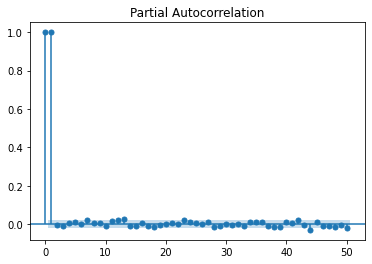

In [17]:
#use PACF to find ideal P value
#we will just use the closing values for now
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(train["Close"], lags=50)
plt.show()

We can see that the stock price is correlated strongly at a time lag of 1, (ie yesterdays price) howevever there is not much correlation between the price of two days ago. In the AFC plot you will see the correlation from the prevouse day carry over.

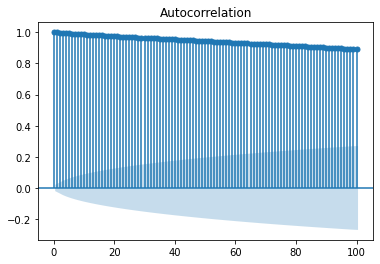

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Close"], lags= 100)
plt.show()

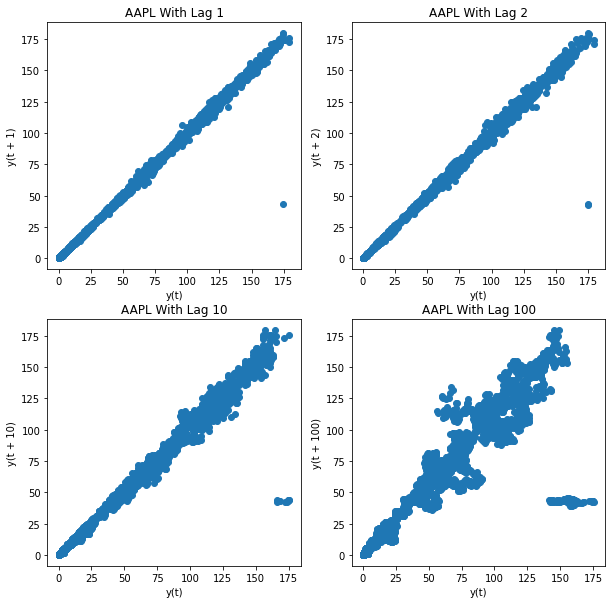

In [19]:
from pandas.plotting import lag_plot


fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (10,10))
lag_plot(df["Close"], lag=1, ax=axes[0,0])
lag_plot(df["Close"], lag=2, ax=axes[0,1])
lag_plot(df["Close"], lag=10, ax=axes[1,0])
lag_plot(df["Close"], lag=100, ax=axes[1,1])
axes[0,0].title.set_text("AAPL With Lag 1")
axes[0,1].title.set_text("AAPL With Lag 2")
axes[1,0].title.set_text("AAPL With Lag 10")
axes[1,1].title.set_text("AAPL With Lag 100")

plt.show()

In [20]:
#build the AR Model with lag 1
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from math import sqrt

model = AutoReg(train["Close"], lags = 5, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 9151
Model:                     AutoReg(5)   Log Likelihood              -17161.222
Method:               Conditional MLE   S.D. of innovations              1.580
Date:                Fri, 24 Dec 2021   AIC                              0.916
Time:                        19:58:47   BIC                              0.922
Sample:                             5   HQIC                             0.918
                                 9151                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0257      0.020      1.294      0.196      -0.013       0.065
Close.L1       0.9990      0.010     95.538      0.000       0.979       1.019
Close.L2       0.0078      0.015      0.530      0.5

In [21]:
pred = model_fit.predict(start=len(train), end=len(train) + len(test),dynamic=False)
pred.iloc[1]

132.6665521505912

c:\Users\BrianBeinBrohan\projects\pytorch tutorials\env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


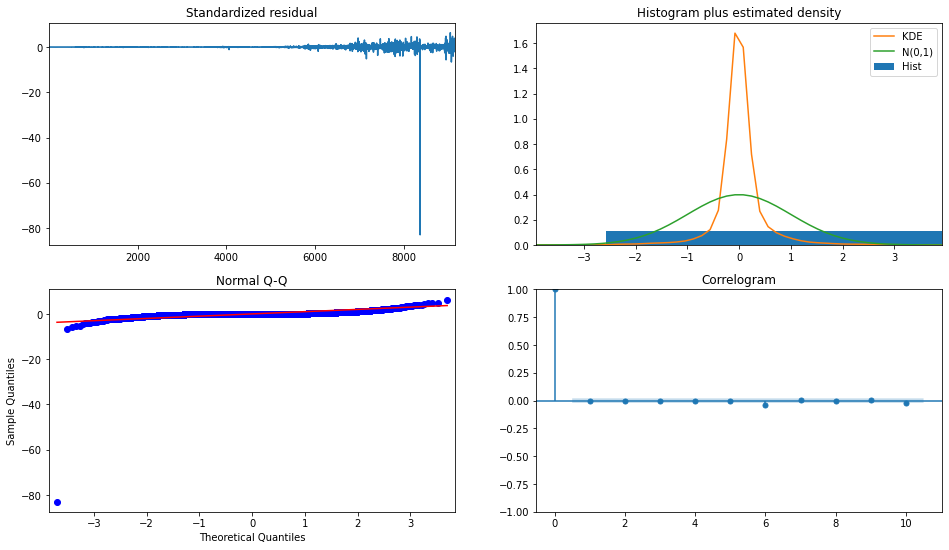

In [22]:
fig = plt.figure(figsize=(16, 9))
fig = model_fit.plot_diagnostics(fig=fig, lags=10)

129.410004
131.009995
126.599998
130.919998
132.050003
128.979996
128.800003
130.889999
128.910004
127.139999
127.830002
132.029999
136.869995
139.070007
142.919998
143.160004
142.059998
137.089996
131.960007
134.139999
134.990005
133.940002
137.389999
136.759995
136.910004
136.009995
135.389999
135.130005
135.369995
133.190002
130.839996
129.710007
129.869995
126.0
125.860001
125.349998
120.989998
121.260002
127.790001
125.120003
122.059998
120.129997
121.419998
116.360001
121.089996
119.980003
121.959999
121.029999
123.989998
125.57
124.760002
120.529999
119.989998
123.389999
122.540001
120.089996
120.589996
121.209999
121.389999
119.900002
122.150002
123.0
125.900002
126.209999
127.900002
130.360001
133.0
131.240005
134.429993
132.029999
134.5
134.160004
134.839996
133.110001
133.5
131.940002
134.320007
134.720001
134.389999
133.580002
133.479996
131.460007
132.539993
127.849998
128.100006
129.740005
130.210007
126.849998
125.910004
122.769997
124.970001
127.449997
126.269997
124.84

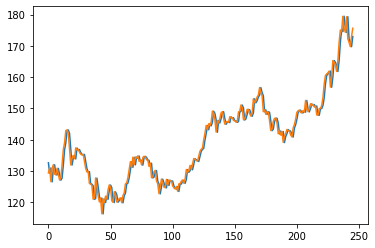

In [27]:
#now there seems to be a problem here? What is it, well we are trying to predict a years worth of data using data from a year ago, essnetially 100+ time lags back, so
#we have to keep updating the model each time lag

#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
lag_1_pred = []

test = test.reset_index(drop=True)

for i in range(len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()
    lag_1_pred.append(model_fit.predict(start=len(train), end=len(train) + 1).iloc[1])
    close_val = test.iloc[i]["Close"]
    train = train.append({"Close": close_val}, ignore_index=True)


plt.plot(lag_1_pred)
plt.plot(test["Close"])
plt.show()
    

